### Initialization

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from os import path
import json
from ast import literal_eval
from public_MAPE import score_function
from time import time
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
from scipy.signal import butter, lfilter
width=15.0
height=7.0
plt.style.use("bmh")
matplotlib.rcParams['figure.figsize'] = (width, height)
all_colors = [parameter['color'] for parameter in plt.rcParams['axes.prop_cycle']]

In [3]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer

### Load data

In [4]:
data_dir = "data"

train = pd.read_csv(path.join("CNN_pipeline", data_dir, "train_input.csv"), sep=';', index_col=0)
ages = pd.read_csv(path.join("CNN_pipeline", data_dir, "train_output.csv"), sep=';', index_col=0)

# Signal preprocessing

### Constants

In [5]:
fs = 250.0 # sampling frequency
N = 75000 # number of points
T = 1.0/fs

In [6]:
n = int(20*fs) # 20 sec * fs, new number of cols of EEG
xtime = np.arange(n) / fs # time abcisses
xfreq = np.linspace(0.0, 1.0/(2.0*T), n//2+1) # freq abcisses

params={"lowcut": 0.5, "highcut": 20.0, "band_name": "all", 
            "filter_data": False, "augment_data": False, "normalize_specter": False}
if not params["augment_data"]:
    n = N

In [7]:
lowcut = params["lowcut"]
highcut = params["highcut"]
bands = {"delta": (0.5, 4.0), "theta": (4.0, 8.0), "alpha": (8.0, 14.0), "beta": (14.0, 20.0), "all": (lowcut, highcut)}

### Filtrer

In [8]:
def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [9]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [10]:
def filter_signals(row, lowcut, highcut, fs, order=6):
    signal_filtered = butter_bandpass_filter(row, lowcut, highcut, fs, order=order)
    return signal_filtered

In [11]:
def filter_EEG(EEG, params, fs):
    if params["filter_data"]:
        return EEG.apply(filter_signals, args=(params["lowcut"], params["highcut"], fs,), axis=1)
    else:
        return EEG

### Data augmentation

In [12]:
#n is the size of one subsample
def augmentData(x,y,n):
    (dudes, N) = x.shape
    x = x.values
    y = y.values
    newX = x.reshape((dudes*N//n, n))
    newY = np.repeat(y, N//n)
    return pd.DataFrame(newX), pd.DataFrame(newY)

In [13]:
def augment_EEG(EEG, ages, params, n):
    if params["augment_data"]:
        return augmentData(EEG, ages, n)
    else:
        return EEG, ages

### Periodogram

In [14]:
def get_periodogram(row, fs):
    data = row.values.astype("float64")
    f, Pxx_den = signal.periodogram(data, fs)
    return pd.Series(Pxx_den)

In [15]:
def periodogram_EEG(EEG, fs):
    return EEG.apply(get_periodogram, args=(fs,), axis=1)

In [16]:
def truncat_specter(specter, n, fs, bands, params):
    band_name = params["band_name"]
    (begin, end) = bands[band_name]
    lowind = int(begin*n/fs)
    highind = int(end*n/fs)
    specter = specter.iloc[:, lowind:highind+1] # we take only the freq between lowcut and highcut
    if params["normalize_specter"]: specter = specter / specter.max(axis=0) # we normalize the spectre
    return specter

### All process

In [17]:
def preprocess_signal(df, ages, params, n, bands):
    EEG = df.iloc[:, 1:-1]
    EEG = filter_EEG(EEG, params, fs)
    EEG, ages = augment_EEG(EEG, ages, params, n)
    specter = periodogram_EEG(EEG, fs)
    specter = truncat_specter(specter, n, fs, bands, params)
    return specter, ages

In [18]:
specter, ages_new = preprocess_signal(train, ages, params, n, bands)

# Dimensionality reduction

In [19]:
X = specter.values
y = ages_new.values.ravel()
feature_names = list(fs*specter.columns/n)

## RandomForest

In [20]:
scorer = make_scorer(score_function, greater_is_better=False)

In [21]:
#tuned_parameters = [{'n_estimators': [5, 10, 15, 20, 50, 100, 200, 500],
#                     'min_samples_leaf': [1, 5, 10, 50, 100, 200, 500],
#                    'oob_score': [True, False]}]
tuned_parameters = [{'n_estimators': [100],
                     'min_samples_leaf': [5],
                    'oob_score': [True]}]

In [22]:
X.shape

(581, 5851)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
reg = GridSearchCV(rf, tuned_parameters, cv=5, n_jobs=-1, verbose=1,
                       scoring=scorer)

In [25]:
reg.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100], 'oob_score': [True], 'min_samples_leaf': [5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(score_function, greater_is_better=False),
       verbose=1)

In [26]:
print "best parameters"
print reg.best_params_
print "best score"
print -reg.best_score_

best parameters
{'n_estimators': 100, 'oob_score': True, 'min_samples_leaf': 5}
best score
27.3002211756


28.140547008981855

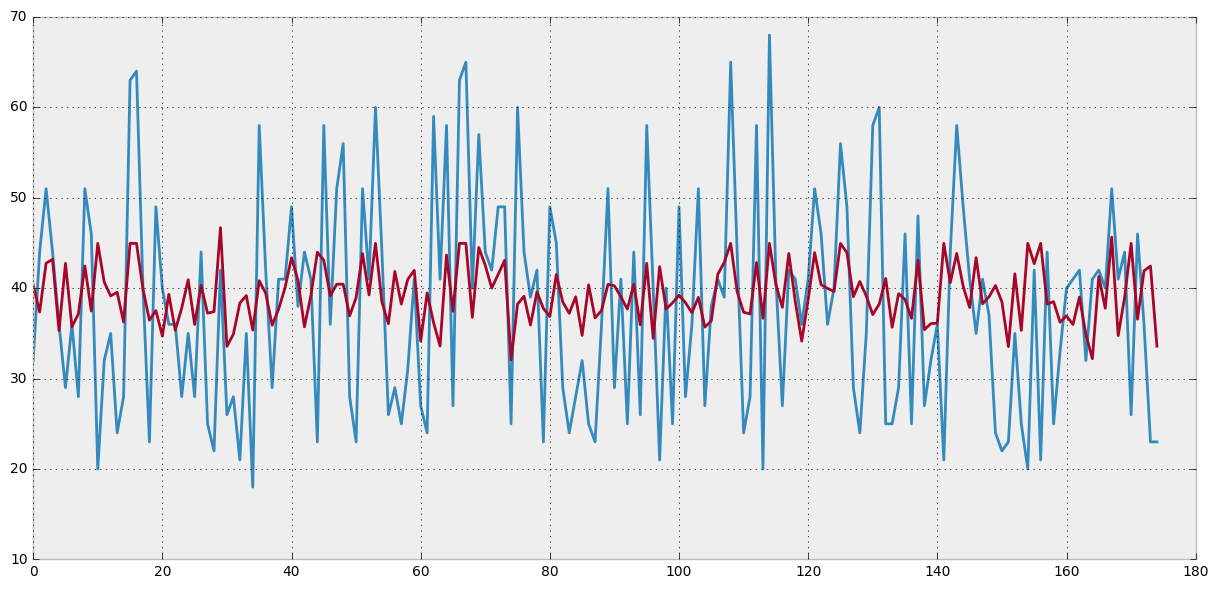

In [27]:
y_pred = reg.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
score_function(y_test, y_pred)

In [28]:
features = pd.DataFrame([])
top_features = pd.DataFrame([])
features["freq"] = feature_names
features["freq_round"] = np.around(feature_names)
features["importance"] = reg.best_estimator_.feature_importances_
top_features["sum"] = features[["freq_round", "importance"]].groupby("freq_round").sum()
top_features["mean"] = features[["freq_round", "importance"]].groupby("freq_round").mean()

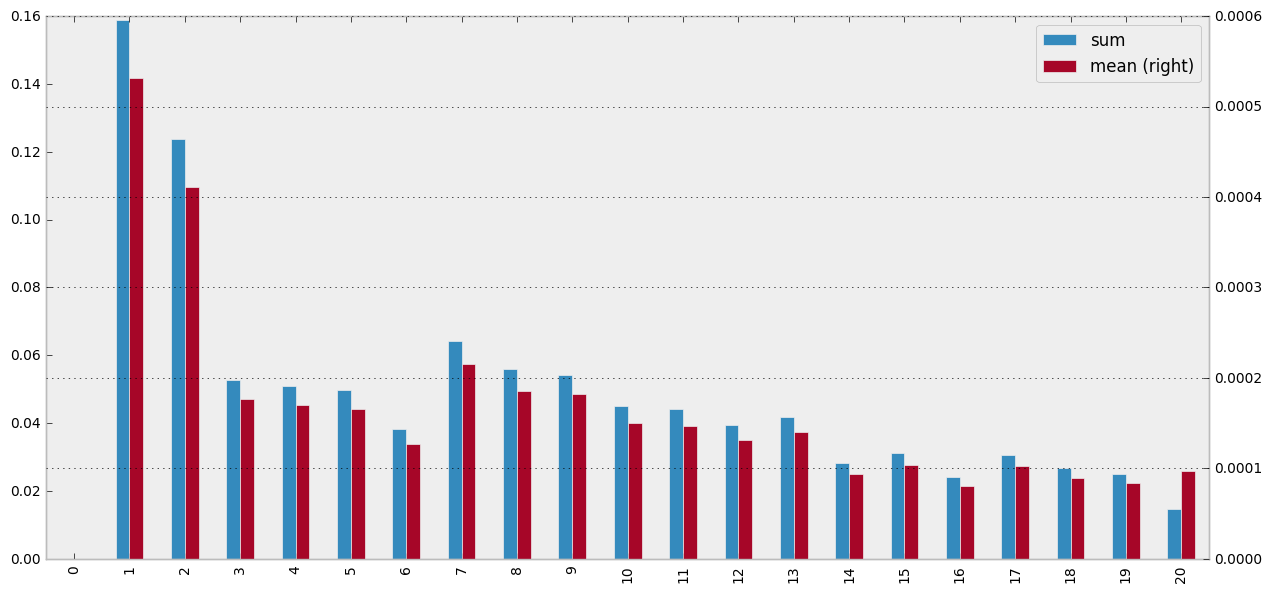

In [29]:
top_features.plot(kind="bar", secondary_y='mean')
#plt.savefig("RF_EEG/RF_augmentation_20.png")

In [30]:
features_sorted = features.sort_values("importance", ascending=False).iloc[:1000]
index_to_keep = list(features_sorted.index)

In [31]:
X = specter.iloc[:,index_to_keep]

# Regressor

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
#tuned_parameters = [{'C': [0.1, 1, 10],
#                     'kernel': ["rbf"],
#                     'gamma': ["auto", 0.1, 0.01, 1, 5],
#                     'shrinking': [True, False]}]
#tuned_parameters = [{'C': [0.1, 1, 10],
#                    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']}]
tuned_parameters = [{'alpha': [0.1, 1, 10],
                    'normalize': [True, False]}]

In [34]:
reg = GridSearchCV(Ridge(random_state=42), tuned_parameters, cv=5, n_jobs=-1, verbose=1,
                       scoring=scorer)

In [35]:
reg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'normalize': [True, False], 'alpha': [0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(score_function, greater_is_better=False),
       verbose=1)

In [36]:
print "best parameters"
print reg.best_params_
print "best score"
print -reg.best_score_

best parameters
{'normalize': True, 'alpha': 10}
best score
109.064370884


30.171066646026084

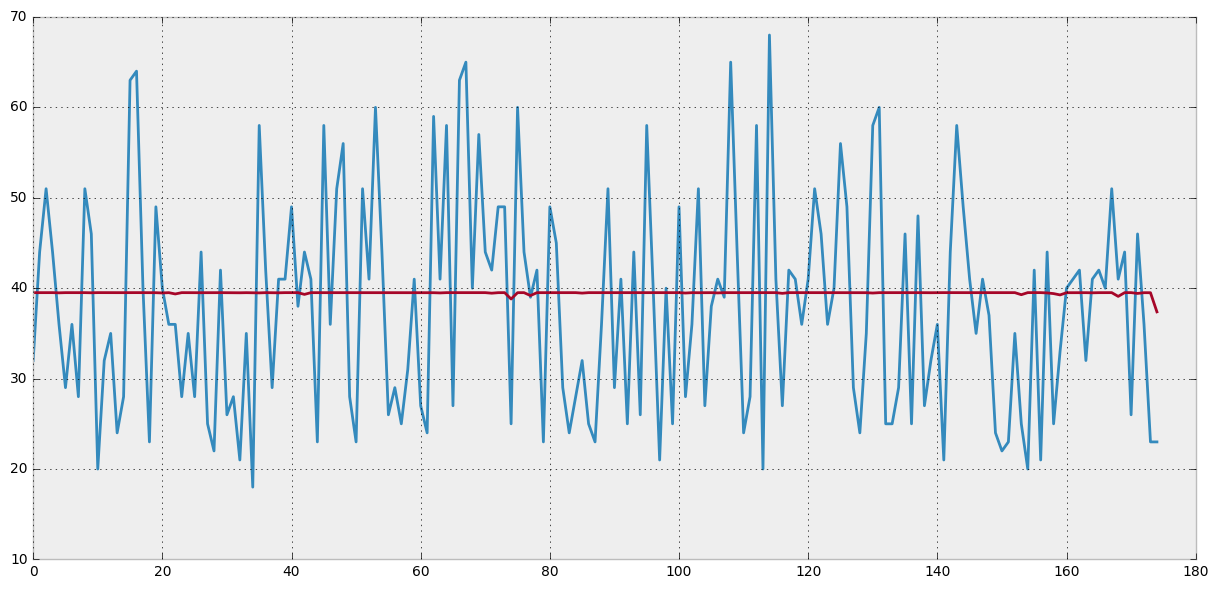

In [37]:
y_pred = reg.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
score_function(y_test, y_pred)